# Single XGBoost model

In [2]:
import sys
import os

# Adjust the path to point to your project root (the folder containing 'src')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_log_error
import wandb
import importlib
import src.preprocessing as prep
importlib.reload(prep)

<module 'src.preprocessing' from '/Users/wpw555/Documents/Kaggle/playground_s5e5/src/preprocessing.py'>

In [4]:
wandb.login(key="0aaf3a0cef734fd8a0c505e1d077ed9d13ab5095")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/wpw555/.netrc
wandb: Currently logged in as: benmcguirk (benmcguirk-queen-mary-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
sweep_config = {
    'method': 'bayes',  # or 'grid', 'random'
    'metric': {'name': 'rmsle', 'goal': 'minimize'},
    'parameters': {
        'learning_rate': {'min': 0.01, 'max': 0.3},
        'max_depth': {'values': [3, 5, 7]},
        'n_estimators': {'min': 100, 'max': 1000},
    }
}

In [6]:
# Set paths
DATA_PATH = '../data/raw/train.csv'
PREPROCESSOR_PATH = '../src/preprocessor.pkl'

# Load the data
data = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (750000, 9)


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [7]:
data.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories'],
      dtype='object')

In [8]:
# Clean data
cleaned_data = prep.clean_train_data(data)

# Split into training and validation sets
X = data.drop(columns=['id', 'Calories'])
X = prep.create_features(X)
y = data['Calories']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit preprocessor
preprocessor = prep.build_preprocessor(X_train)
X_train_processed, X_val_processed = prep.fit_and_transform_preprocessor(preprocessor, X_train, X_val)

# Save preprocessor
joblib.dump(preprocessor, PREPROCESSOR_PATH)

['../src/preprocessor.pkl']

In [12]:
# Define training function
def train():
    with wandb.init() as run:
        config = run.config
        model = xgb.XGBRegressor(
            learning_rate=config.learning_rate,
            max_depth=config.max_depth,
            n_estimators=config.n_estimators,
            random_state=42
        )
        model.fit(X_train_processed, y_train, eval_set=[(X_val_processed, y_val)], verbose=False)
        preds = model.predict(X_val_processed)
        preds = np.maximum(preds, 0) # clip predictions to ensure they are non-negative
        rmsle = np.sqrt(mean_squared_log_error(y_val, preds))
        wandb.log({
            "rmsle": rmsle,
            "learning_rate": config.learning_rate,
            "max_depth": config.max_depth,
            "n_estimators": config.n_estimators
        })

# Start sweep
sweep_id = wandb.sweep(sweep_config, project="xgboost-optimization")
wandb.agent(sweep_id, function=train, count=50)

Create sweep with ID: kk3lk19c
Sweep URL: https://wandb.ai/benmcguirk-queen-mary-university-of-london/xgboost-optimization/sweeps/kk3lk19c


wandb: Agent Starting Run: g1raipa0 with config:
wandb: 	learning_rate: 0.2987653346734741
wandb: 	max_depth: 5
wandb: 	n_estimators: 729


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.29877
max_depth,5
n_estimators,729
rmsle,0.00428


wandb: Agent Starting Run: o6pnw1zg with config:
wandb: 	learning_rate: 0.2568891176098514
wandb: 	max_depth: 5
wandb: 	n_estimators: 289


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.25689
max_depth,5
n_estimators,289
rmsle,0.00423


wandb: Agent Starting Run: gte035bh with config:
wandb: 	learning_rate: 0.25125562491900066
wandb: 	max_depth: 5
wandb: 	n_estimators: 276


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.25126
max_depth,5
n_estimators,276
rmsle,0.00426


wandb: Agent Starting Run: oynl1fkg with config:
wandb: 	learning_rate: 0.2770330269872484
wandb: 	max_depth: 5
wandb: 	n_estimators: 553


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.27703
max_depth,5
n_estimators,553
rmsle,0.0041


wandb: Agent Starting Run: w7imwwir with config:
wandb: 	learning_rate: 0.2750830581977992
wandb: 	max_depth: 3
wandb: 	n_estimators: 656


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.27508
max_depth,3
n_estimators,656
rmsle,0.00481


wandb: Agent Starting Run: i483klb5 with config:
wandb: 	learning_rate: 0.27293419200384383
wandb: 	max_depth: 7
wandb: 	n_estimators: 473


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.27293
max_depth,7
n_estimators,473
rmsle,0.00397


wandb: Agent Starting Run: q5g1twfd with config:
wandb: 	learning_rate: 0.2820667037792405
wandb: 	max_depth: 7
wandb: 	n_estimators: 503


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.28207
max_depth,7
n_estimators,503
rmsle,0.00395


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fbo31dtu with config:
wandb: 	learning_rate: 0.27238313909584627
wandb: 	max_depth: 7
wandb: 	n_estimators: 641


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.27238
max_depth,7
n_estimators,641
rmsle,0.00395


wandb: Agent Starting Run: k64uklx2 with config:
wandb: 	learning_rate: 0.28641138177707365
wandb: 	max_depth: 7
wandb: 	n_estimators: 537


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.28641
max_depth,7
n_estimators,537
rmsle,0.00418


wandb: Agent Starting Run: f91ipr4n with config:
wandb: 	learning_rate: 0.24578910474359997
wandb: 	max_depth: 5
wandb: 	n_estimators: 312


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.24579
max_depth,5
n_estimators,312
rmsle,0.00425


wandb: Agent Starting Run: xes3wrgw with config:
wandb: 	learning_rate: 0.12670972484623502
wandb: 	max_depth: 5
wandb: 	n_estimators: 751


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.12671
max_depth,5
n_estimators,751
rmsle,0.00397


wandb: Agent Starting Run: o59ly9nb with config:
wandb: 	learning_rate: 0.2805643371475091
wandb: 	max_depth: 7
wandb: 	n_estimators: 645


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.28056
max_depth,7
n_estimators,645
rmsle,0.004


wandb: Agent Starting Run: 8k7ajkgg with config:
wandb: 	learning_rate: 0.13939937816145853
wandb: 	max_depth: 3
wandb: 	n_estimators: 492


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.1394
max_depth,3
n_estimators,492
rmsle,0.00514


wandb: Agent Starting Run: cdswkoks with config:
wandb: 	learning_rate: 0.2481805135004256
wandb: 	max_depth: 7
wandb: 	n_estimators: 591


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.24818
max_depth,7
n_estimators,591
rmsle,0.00393


wandb: Agent Starting Run: 2lw3kimj with config:
wandb: 	learning_rate: 0.24892377201395613
wandb: 	max_depth: 7
wandb: 	n_estimators: 735


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.24892
max_depth,7
n_estimators,735
rmsle,0.00391


wandb: Agent Starting Run: 7jfyy3go with config:
wandb: 	learning_rate: 0.22156317250847857
wandb: 	max_depth: 7
wandb: 	n_estimators: 676


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.22156
max_depth,7
n_estimators,676
rmsle,0.00396


wandb: Agent Starting Run: jkaubrqk with config:
wandb: 	learning_rate: 0.24425367361649897
wandb: 	max_depth: 7
wandb: 	n_estimators: 638


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.24425
max_depth,7
n_estimators,638
rmsle,0.00395


wandb: Agent Starting Run: 585yy48b with config:
wandb: 	learning_rate: 0.22809619392316835
wandb: 	max_depth: 7
wandb: 	n_estimators: 778


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.2281
max_depth,7
n_estimators,778
rmsle,0.00393


wandb: Agent Starting Run: dnm15il7 with config:
wandb: 	learning_rate: 0.17638259971717216
wandb: 	max_depth: 7
wandb: 	n_estimators: 787


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.17638
max_depth,7
n_estimators,787
rmsle,0.00391


wandb: Agent Starting Run: 7mgfmujk with config:
wandb: 	learning_rate: 0.16431657336252473
wandb: 	max_depth: 7
wandb: 	n_estimators: 843


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.16432
max_depth,7
n_estimators,843
rmsle,0.00388


wandb: Agent Starting Run: jnnj92p8 with config:
wandb: 	learning_rate: 0.13039088631992785
wandb: 	max_depth: 7
wandb: 	n_estimators: 836


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.13039
max_depth,7
n_estimators,836
rmsle,0.00387


wandb: Agent Starting Run: v89y5t7e with config:
wandb: 	learning_rate: 0.13933540255623925
wandb: 	max_depth: 7
wandb: 	n_estimators: 901


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.13934
max_depth,7
n_estimators,901
rmsle,0.00386


wandb: Agent Starting Run: 18948m43 with config:
wandb: 	learning_rate: 0.13510555967787738
wandb: 	max_depth: 7
wandb: 	n_estimators: 874


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.13511
max_depth,7
n_estimators,874
rmsle,0.00389


wandb: Agent Starting Run: ibr5e4ay with config:
wandb: 	learning_rate: 0.14426223213861672
wandb: 	max_depth: 7
wandb: 	n_estimators: 910


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.14426
max_depth,7
n_estimators,910
rmsle,0.00388


wandb: Agent Starting Run: 0m3h7tq3 with config:
wandb: 	learning_rate: 0.10477508927643708
wandb: 	max_depth: 7
wandb: 	n_estimators: 891


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.10478
max_depth,7
n_estimators,891
rmsle,0.00383


wandb: Agent Starting Run: znjyp3p7 with config:
wandb: 	learning_rate: 0.10724242482445036
wandb: 	max_depth: 7
wandb: 	n_estimators: 856


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.10724
max_depth,7
n_estimators,856
rmsle,0.00381


wandb: Agent Starting Run: mbyhellc with config:
wandb: 	learning_rate: 0.0945302550899001
wandb: 	max_depth: 7
wandb: 	n_estimators: 842


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.09453
max_depth,7
n_estimators,842
rmsle,0.00383


wandb: Agent Starting Run: jlv9uwph with config:
wandb: 	learning_rate: 0.11323117340822444
wandb: 	max_depth: 7
wandb: 	n_estimators: 820


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.11323
max_depth,7
n_estimators,820
rmsle,0.00384


wandb: Agent Starting Run: 4jcz1kh4 with config:
wandb: 	learning_rate: 0.09908811191978666
wandb: 	max_depth: 7
wandb: 	n_estimators: 935


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.09909
max_depth,7
n_estimators,935
rmsle,0.00384


wandb: Agent Starting Run: ek7c3bjp with config:
wandb: 	learning_rate: 0.10925450868181628
wandb: 	max_depth: 7
wandb: 	n_estimators: 985


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.10925
max_depth,7
n_estimators,985
rmsle,0.00382


wandb: Agent Starting Run: 0haihhl3 with config:
wandb: 	learning_rate: 0.10829564293606926
wandb: 	max_depth: 7
wandb: 	n_estimators: 955


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.1083
max_depth,7
n_estimators,955
rmsle,0.00383


wandb: Agent Starting Run: kzizqsxk with config:
wandb: 	learning_rate: 0.09264902001194068
wandb: 	max_depth: 7
wandb: 	n_estimators: 898


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.09265
max_depth,7
n_estimators,898
rmsle,0.00385


wandb: Agent Starting Run: 2rdv6027 with config:
wandb: 	learning_rate: 0.1151112167779088
wandb: 	max_depth: 7
wandb: 	n_estimators: 996


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.11511
max_depth,7
n_estimators,996
rmsle,0.00388


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vrv64uz6 with config:
wandb: 	learning_rate: 0.10679875778693244
wandb: 	max_depth: 7
wandb: 	n_estimators: 936


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.1068
max_depth,7
n_estimators,936
rmsle,0.00387


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: foh9moly with config:
wandb: 	learning_rate: 0.0551841423367496
wandb: 	max_depth: 7
wandb: 	n_estimators: 998


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.05518
max_depth,7
n_estimators,998
rmsle,0.00382


wandb: Agent Starting Run: vq1ntbeh with config:
wandb: 	learning_rate: 0.090543263065109
wandb: 	max_depth: 7
wandb: 	n_estimators: 917


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.09054
max_depth,7
n_estimators,917
rmsle,0.00386


wandb: Agent Starting Run: 824plw5i with config:
wandb: 	learning_rate: 0.05945092528224721
wandb: 	max_depth: 7
wandb: 	n_estimators: 986


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.05945
max_depth,7
n_estimators,986
rmsle,0.00381


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dv5jfkva with config:
wandb: 	learning_rate: 0.0874760818533417
wandb: 	max_depth: 7
wandb: 	n_estimators: 991


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.08748
max_depth,7
n_estimators,991
rmsle,0.00384


wandb: Agent Starting Run: zq3kqlh1 with config:
wandb: 	learning_rate: 0.09517267916682225
wandb: 	max_depth: 7
wandb: 	n_estimators: 907


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.09517
max_depth,7
n_estimators,907
rmsle,0.00383


wandb: Agent Starting Run: 97if9b18 with config:
wandb: 	learning_rate: 0.10284424541415758
wandb: 	max_depth: 7
wandb: 	n_estimators: 934


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.10284
max_depth,7
n_estimators,934
rmsle,0.00391


wandb: Agent Starting Run: ee4fqoni with config:
wandb: 	learning_rate: 0.257980329354878
wandb: 	max_depth: 3
wandb: 	n_estimators: 851


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.25798
max_depth,3
n_estimators,851
rmsle,0.00472


wandb: Agent Starting Run: lljlaq8p with config:
wandb: 	learning_rate: 0.11092542703834718
wandb: 	max_depth: 7
wandb: 	n_estimators: 901


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.11093
max_depth,7
n_estimators,901
rmsle,0.00385


wandb: Agent Starting Run: 54ted0e5 with config:
wandb: 	learning_rate: 0.08398686853919232
wandb: 	max_depth: 7
wandb: 	n_estimators: 942


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.08399
max_depth,7
n_estimators,942
rmsle,0.00386


wandb: Agent Starting Run: 2lrp9s0l with config:
wandb: 	learning_rate: 0.10116218848760895
wandb: 	max_depth: 7
wandb: 	n_estimators: 898


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.10116
max_depth,7
n_estimators,898
rmsle,0.00389


wandb: Agent Starting Run: d21r4zy3 with config:
wandb: 	learning_rate: 0.17484372045675445
wandb: 	max_depth: 3
wandb: 	n_estimators: 399


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.17484
max_depth,3
n_estimators,399
rmsle,0.00537


wandb: Agent Starting Run: 4affqw30 with config:
wandb: 	learning_rate: 0.09577733789588808
wandb: 	max_depth: 7
wandb: 	n_estimators: 847


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.09578
max_depth,7
n_estimators,847
rmsle,0.00381


wandb: Agent Starting Run: q4mkmo38 with config:
wandb: 	learning_rate: 0.10338712277549146
wandb: 	max_depth: 7
wandb: 	n_estimators: 899


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.10339
max_depth,7
n_estimators,899
rmsle,0.00388


wandb: Agent Starting Run: p8k6u69f with config:
wandb: 	learning_rate: 0.1029119023464464
wandb: 	max_depth: 7
wandb: 	n_estimators: 839


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.10291
max_depth,7
n_estimators,839
rmsle,0.00381


wandb: Agent Starting Run: sca7yv3i with config:
wandb: 	learning_rate: 0.0975668829948364
wandb: 	max_depth: 7
wandb: 	n_estimators: 955


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.09757
max_depth,7
n_estimators,955
rmsle,0.00387


wandb: Agent Starting Run: p9t5k22l with config:
wandb: 	learning_rate: 0.10646011872970676
wandb: 	max_depth: 7
wandb: 	n_estimators: 891


learning_rate,▁
max_depth,▁
n_estimators,▁
rmsle,▁
learning_rate,0.10646
max_depth,7
n_estimators,891
rmsle,0.00386


In [13]:
# Create and train the xgb model
best_model = xgb.XGBRegressor(learning_rate=0.10724, max_depth=7, n_estimators=856, random_state=42)
best_model.fit(X_train_processed, y_train)

# Make predictions
y_train_pred = best_model.predict(X_train_processed)
y_val_pred = best_model.predict(X_val_processed)

In [14]:
# Clip predictions to ensure they are non-negative
y_train_pred = np.clip(y_train_pred, 0, None)
y_val_pred = np.clip(y_val_pred, 0, None)

In [15]:
# Evaluate the model
train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
val_rmsle = np.sqrt(mean_squared_log_error(y_val, y_val_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training RMSLE: {train_rmsle:.4f}")
print(f"Validation RMSLE: {val_rmsle:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")

Training RMSLE: 0.0561
Validation RMSLE: 0.0619
Training R²: 0.9978
Validation R²: 0.9966


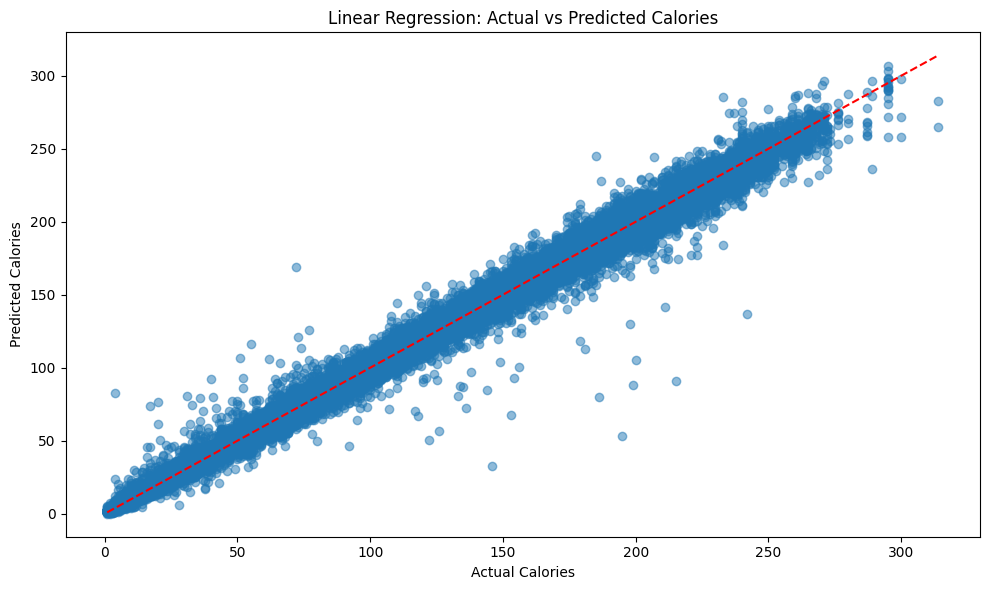

In [16]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.title('Linear Regression: Actual vs Predicted Calories')
plt.tight_layout()
plt.show()

In [17]:
# Save the model
joblib.dump(best_model, '../output/models/XGBoost_model_wandb.pkl')
print("Model saved successfully!")

Model saved successfully!


In [18]:
# Load the test data
test_data = pd.read_csv('../data/raw/test.csv')

# Clean the test data
cleaned_test_data = prep.clean_test_data(test_data)

# Split into features and target
X_test = cleaned_test_data.drop(columns=['id'])
X_test = prep.create_features(X_test)

# Transform the test features using the fitted preprocessor
X_test_processed = preprocessor.transform(X_test)

# 2. Make predictions using the fitted model
y_test_pred = best_model.predict(X_test_processed)
y_test_pred = np.clip(y_test_pred, 0, None)

In [19]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'Calories': y_test_pred
})
submission.to_csv('../output/submissions/XGBoost_wandb.csv', index=False)